<a href="https://colab.research.google.com/github/jatinsharmagit/Data-Science-Projects/blob/main/Data-Science-Projects%20/Time%20Series%20Forecasting/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-optimize

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import holidays
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Integer, Real
from statsmodels.tsa.seasonal import STL
from scipy.fft import fft, fftfreq
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [ ]:
# Step 1: Load the data from Excel
file_path = "/content/drive/My Drive/Colab Notebooks/time series/sales.xlsx"  # Replace with actual file path
df = pd.read_excel(file_path)

In [ ]:
df.columns

Index(['Date', 'sales'], dtype='object')

In [ ]:
df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"])

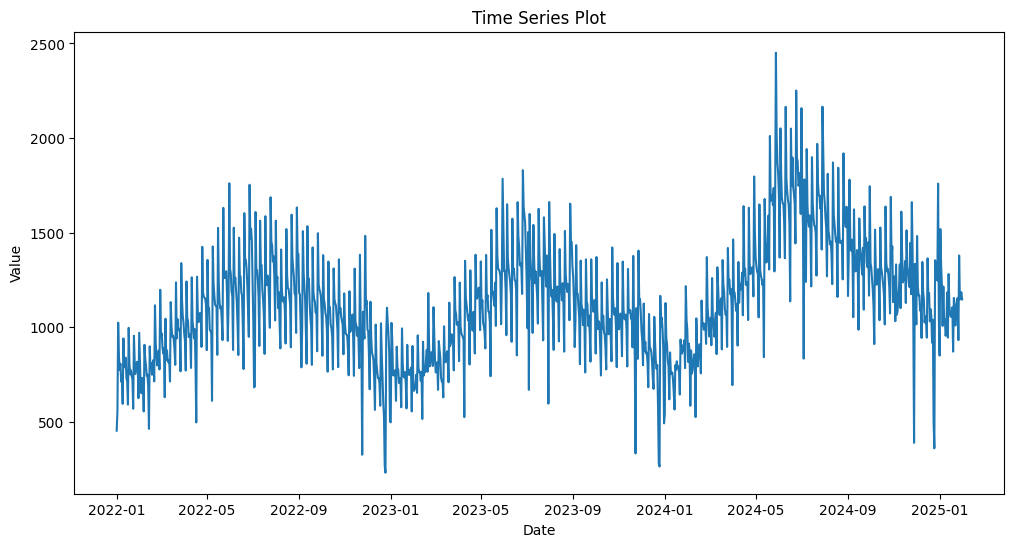

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

##Checking for different seasonalities in time series

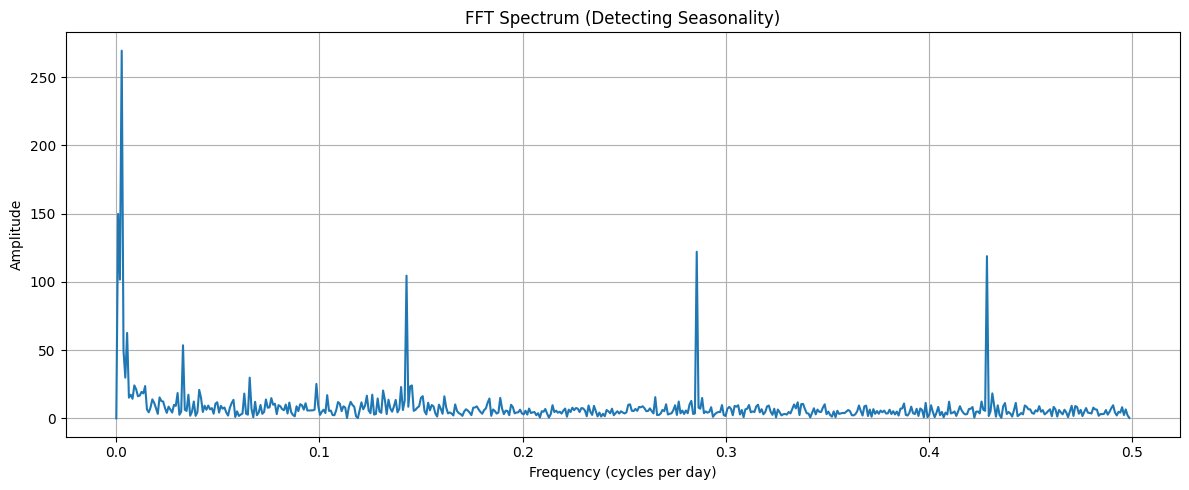

Top frequency peaks and their corresponding periods (in days):
Frequency: 0.0027 → Period: 375.67 days, Amplitude: 269.40
Frequency: 0.0009 → Period: 1127.00 days, Amplitude: 149.79
Frequency: 0.2857 → Period: 3.50 days, Amplitude: 122.09
Frequency: 0.4286 → Period: 2.33 days, Amplitude: 118.84
Frequency: 0.1429 → Period: 7.00 days, Amplitude: 104.57
Frequency: 0.0018 → Period: 563.50 days, Amplitude: 101.68


In [ ]:
# Using Fast Fourier Transform to detst seasonality
df = df.sort_values("ds")
df = df.set_index("ds").asfreq("D")  # Ensure daily frequency
y = df["y"].interpolate()  # Fill missing values if any

# === Step 2: Apply FFT ===
N = len(y)
T = 1.0  # Sampling interval = 1 day
yf = fft(y - y.mean())  # Center the signal before FFT
xf = fftfreq(N, T)[:N // 2]
amplitudes = 2.0 / N * np.abs(yf[:N // 2])

# === Step 3: Plot the FFT spectrum ===
plt.figure(figsize=(12, 5))
plt.plot(xf, amplitudes)
plt.title("FFT Spectrum (Detecting Seasonality)")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 4: Find top frequencies and periods ===
top_indices = amplitudes.argsort()[-6:][::-1]  # Top 5 peaks
print("Top frequency peaks and their corresponding periods (in days):")
for i in top_indices:
    freq = xf[i]
    if freq > 0:
        period = 1 / freq
        print(f"Frequency: {freq:.4f} → Period: {period:.2f} days, Amplitude: {amplitudes[i]:.2f}")

It seems to have strong yearly seasonality

##Using ACF to check for seasonality

<Figure size 1000x600 with 0 Axes>

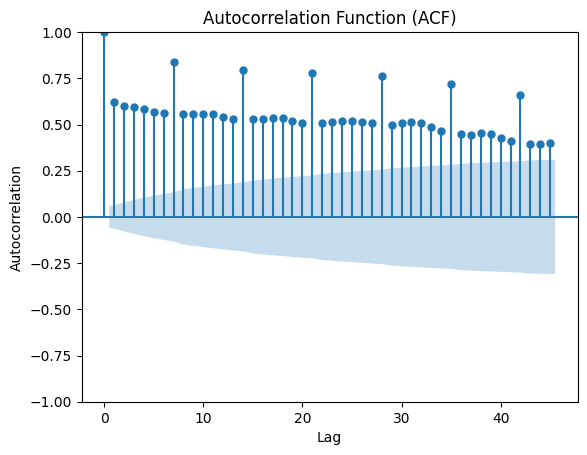

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(df['y'], lags=45)  # Check for lags related to weekly patterns
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Shows strong weekly seasonality.There is a spike in ACF at 7 day interval

<Figure size 1000x600 with 0 Axes>

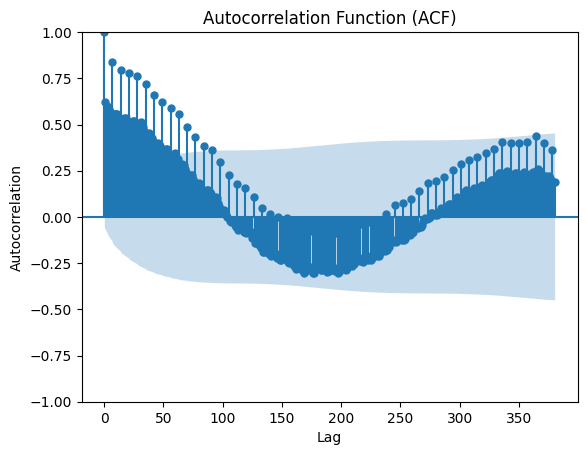

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(df['y'], lags=380)  # Check for lags related to weekly patterns
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The ACF peaks again at 365 indicating yearly seasonality

In [ ]:
df

,y
ds,
2022-01-01,453
2022-01-02,555
2022-01-03,1024
2022-01-04,851
2022-01-05,775
...,...
2025-01-27,1379
2025-01-28,1147
2025-01-29,1169


In [ ]:
df['ds'] = df.index
df = df.reset_index(drop=True)

In [ ]:
df=df[['ds','y']]

In [ ]:
df

,ds,y
0,2022-01-01,453
1,2022-01-02,555
2,2022-01-03,1024
3,2022-01-04,851
4,2022-01-05,775
...,...,...
1122,2025-01-27,1379
1123,2025-01-28,1147
1124,2025-01-29,1169
1125,2025-01-30,1185


## Visual Diagnostic of time series

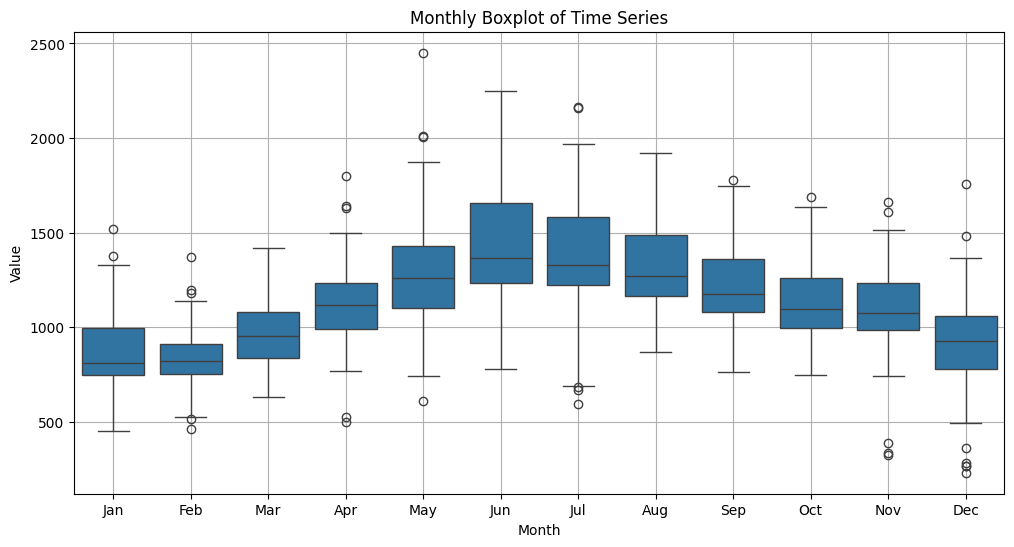

In [ ]:
df["Month"] = df["ds"].dt.strftime('%b')  # Month names like Jan, Feb, ...
df["Month_Num"] = df["ds"].dt.month       # For sorting
df = df.sort_values("Month_Num")

# --- Plot Boxplot by Month ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Month", y="y", data=df, order=pd.date_range("2022-01-01", periods=12, freq="MS").strftime('%b'))
plt.title("Monthly Boxplot of Time Series")
plt.xlabel("Month")
plt.ylabel("Value")
plt.grid(True)
plt.show()

It looks as if June, Jul and August are the busiest seasons for the business

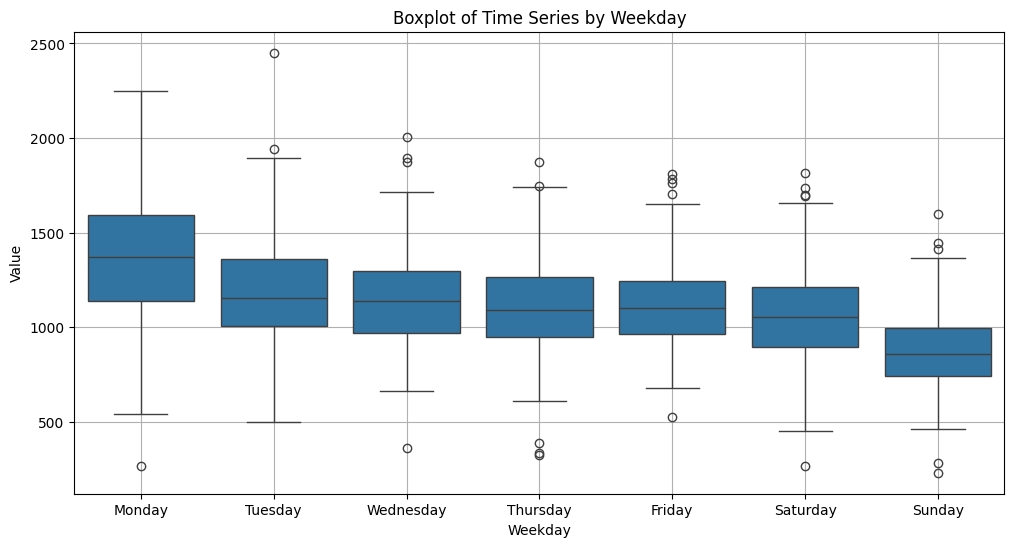

In [ ]:
# --- Extract weekday (0 = Monday, 6 = Sunday) ---
df["Weekday"] = df["ds"].dt.day_name()

# --- Optional: Set weekday order ---
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# --- Plot boxplot by weekday ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Weekday", y="y", data=df, order=weekday_order)
plt.title("Boxplot of Time Series by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Value")
plt.grid(True)
plt.show()

It looks as if Monday is the busiest day of the week

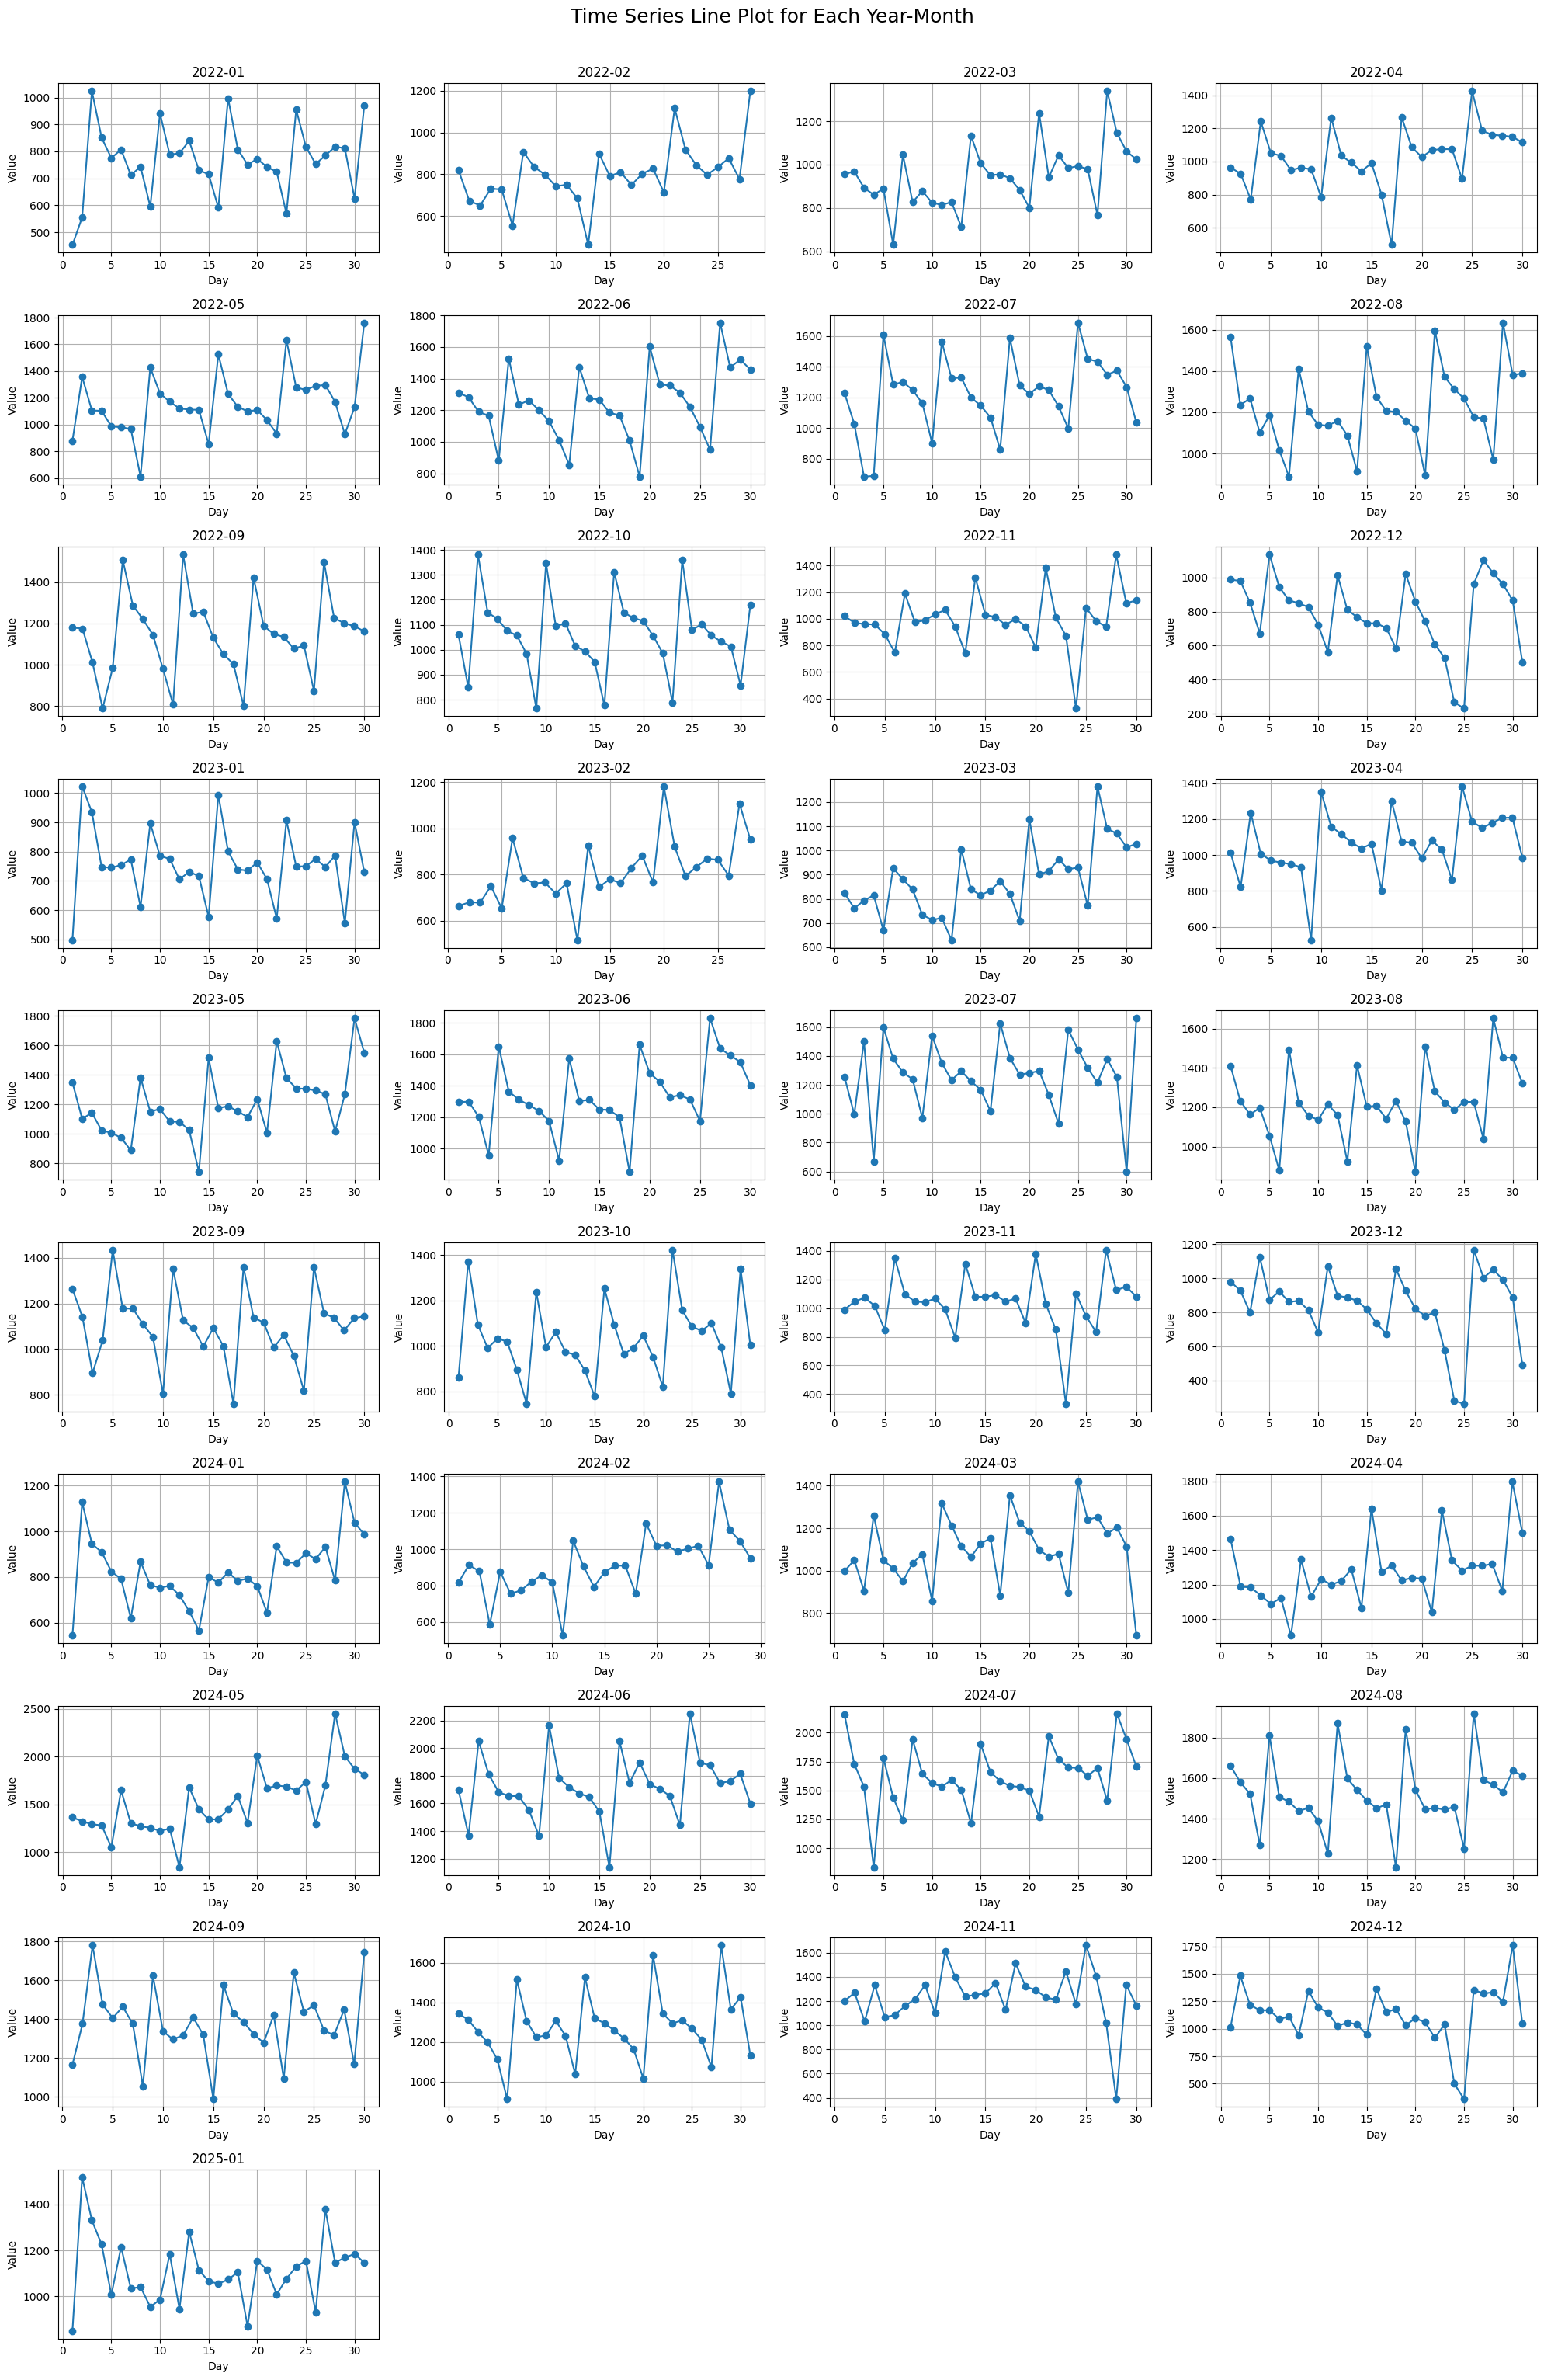

In [ ]:
df["Year"] = df["ds"].dt.year
df["Month"] = df["ds"].dt.month
df["Month_Name"] = df["ds"].dt.strftime('%b')
df["Day"] = df["ds"].dt.day

# --- Sort for consistent order ---
df = df.sort_values(["Year", "Month", "Day"])

# --- Create unique Year-Month label ---
df["YearMonth"] = df["ds"].dt.strftime('%Y-%m')

# --- Plot each Year-Month in its own subplot ---
unique_months = df["YearMonth"].unique()
n = len(unique_months)
cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(20, rows * 3))

for i, ym in enumerate(unique_months, 1):
    subset = df[df["YearMonth"] == ym]
    plt.subplot(rows, cols, i)
    plt.plot(subset["Day"], subset["y"], marker='o', linestyle='-')
    plt.title(ym)
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Time Series Line Plot for Each Year-Month", fontsize=18, y=1.02)
plt.show()

It looks that every the last few days of the month are the busiest

In [ ]:
df.head()

,ds,y,Month,Month_Num,Weekday,Year,Month_Name,Day,YearMonth
0,2022-01-01,453,1,1,Saturday,2022,Jan,1,2022-01
1,2022-01-02,555,1,1,Sunday,2022,Jan,2,2022-01
2,2022-01-03,1024,1,1,Monday,2022,Jan,3,2022-01
3,2022-01-04,851,1,1,Tuesday,2022,Jan,4,2022-01
4,2022-01-05,775,1,1,Wednesday,2022,Jan,5,2022-01


In [ ]:
df=df.drop(columns=["Month","Month_Num","Weekday","Year","Day","YearMonth"])

###Forecasting JAN 2025 using Prophet

In [ ]:
# Load Data
file_path = "/content/drive/My Drive/Colab Notebooks/time series/sales.xlsx"  # Replace with actual file path
df = pd.read_excel(file_path)
df.columns = ["ds", "y"]
df = df.dropna()
df["ds"] = pd.to_datetime(df["ds"])

# As last few days of each month are busy therefore adding a regressor for month end
df['month_end_week'] = ((df['ds'].dt.is_month_end == True) |
                        ((df['ds'] + pd.Timedelta(days=1)).dt.is_month_end) |
                        ((df['ds'] + pd.Timedelta(days=2)).dt.is_month_end) |
                        ((df['ds'] + pd.Timedelta(days=3)).dt.is_month_end) |
                        ((df['ds'] + pd.Timedelta(days=4)).dt.is_month_end)).astype(int)

date_val_end = "2024-12-31"
test_start= "2025-01-01"
test_end="2025-01-31"
train_val = df[df["ds"] <= date_val_end]

test = df[(df["ds"] >= test_start) & (df["ds"] <= test_end)] # test-data

# Handle outliers
train_val.loc[:, "y"] = np.clip(train_val["y"], train_val["y"].quantile(0.01), train_val["y"].quantile(0.99)).astype(np.int64)

# US Holidays
us_holidays = holidays.US(years=range(df["ds"].dt.year.min(), df["ds"].dt.year.max() + 1))
holidays_df = pd.DataFrame({"ds": list(us_holidays.keys()), "holiday": list(us_holidays.values())})

# MAPE Calculation
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Time Series Cross-Validation
def time_series_cv(train_val, weekly_order, yearly_order, changepoint_scale, month_end_prior_scale, n_splits=4, min_train_size=365, test_size=91):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=min(90, len(train_val) // (n_splits + 1)))

    val_rmses, val_mapes = [], []
    train_rmses, train_mapes = [], []

    for train_idx, val_idx in tscv.split(train_val):
        if len(train_idx) < min_train_size:
            continue

        train_subset = train_val.iloc[train_idx].copy()
        val_subset = train_val.iloc[val_idx].reset_index(drop=True)

        # Initialize and train Prophet model
        model = Prophet(changepoint_prior_scale=changepoint_scale)
        if not holidays_df.empty:
            model.add_country_holidays(country_name='US')

        model.add_seasonality(name="weekly", period=7, fourier_order=weekly_order)
        model.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)
        # Add regressors with prior_scale value
        model.add_regressor('month_end_week', prior_scale=month_end_prior_scale)

        model.fit(train_subset)

        # Forecast for train subset
        future_train = train_subset[["ds", "month_end_week"]].copy()
        forecast_train = model.predict(future_train)
        train_forecast = forecast_train[["ds", "yhat"]].merge(train_subset[["ds", "y"]], on="ds", how="right")

        train_rmse = np.sqrt(mean_squared_error(train_forecast["y"], train_forecast["yhat"]))
        train_mape = calculate_mape(train_forecast["y"], train_forecast["yhat"])
        train_rmses.append(train_rmse)
        train_mapes.append(train_mape)

        # Forecast for val subset
        future_val = val_subset[["ds", "month_end_week"]].copy()
        forecast_val = model.predict(future_val)
        val_forecast = forecast_val[["ds", "yhat"]].merge(val_subset[["ds", "y"]], on="ds", how="right")

        val_rmse = np.sqrt(mean_squared_error(val_forecast["y"], val_forecast["yhat"]))
        val_mape = calculate_mape(val_forecast["y"], val_forecast["yhat"])
        val_rmses.append(val_rmse)
        val_mapes.append(val_mape)

    # Return average metrics
    return {
        "train_rmse": np.mean(train_rmses) if train_rmses else float("inf"),
        "train_mape": np.mean(train_mapes) if train_mapes else float("inf"),
        "val_rmse": np.mean(val_rmses) if val_rmses else float("inf"),
        "val_mape": np.mean(val_mapes) if val_mapes else float("inf")
    }


# Bayesian Optimization Function , optimisation based on low mape
def objective(params):
    weekly_order, yearly_order, changepoint_scale, month_end_prior_scale = params
    metrics = time_series_cv(train_val, weekly_order, yearly_order, changepoint_scale, month_end_prior_scale)

    print(f"Params: {params}, Train MAPE: {metrics['train_mape']:.2f}, Val MAPE: {metrics['val_mape']:.2f}")
    return metrics["val_mape"]


# Define Search Space
search_space = [
    Integer(1, 13, name="weekly_order"),
    Integer(1, 7, name="yearly_order"),
    Real(0.001, 0.1, name="changepoint_scale"),
    Real(0.001, 0.1, name="month_end_prior_scale")
]

# Run Bayesian Optimization
result = gp_minimize(objective, search_space, n_calls=70, random_state=42, verbose=True)

# Best Parameters
best_params = {
    "weekly_fourier_order": result.x[0],
    "yearly_fourier_order": result.x[1],
    "changepoint_prior_scale": result.x[2],
    "month_end_prior_scale": result.x[3]
}
best_rms = result.fun

final_metrics = time_series_cv(
    train_val,
    best_params["weekly_fourier_order"],
    best_params["yearly_fourier_order"],
    best_params["changepoint_prior_scale"],
    best_params["month_end_prior_scale"]
)

print("Final Avg Train RMSE:", final_metrics["train_rmse"])
print("Final Avg Train MAPE:", final_metrics["train_mape"])
print("Final Avg Val RMSE:", final_metrics["val_rmse"])
print("Final Avg Val MAPE:", final_metrics["val_mape"])

Iteration No: 1 started. Evaluating function at random point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/v4z_te_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/qic_4yuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96929', 'data', 'file=/tmp/tmpy_g24v6b/v4z_te_c.json', 'init=/tmp/tmpy_g24v6b/qic_4yuh.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelagsm412y/prophet_model-20250421042926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:26 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(11), np.int64(2), 0.07818940902700418, 0.060088165636702225], Train MAPE: 7.02, Val MAPE: 12.52
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.7166
Function value obtained: 12.5206
Current minimum: 12.5206
Iteration No: 2 started. Evaluating function at random point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/txrd370j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62930', 'data', 'file=/tmp/tmpy_g24v6b/z3920wr6.json', 'init=/tmp/tmpy_g24v6b/txrd370j.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelpxy6x6xn/prophet_model-20250421042933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy

Params: [np.int64(6), np.int64(2), 0.046465640304620866, 0.03403715250276317], Train MAPE: 7.13, Val MAPE: 13.26
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.8862
Function value obtained: 13.2561
Current minimum: 12.5206
Iteration No: 3 started. Evaluating function at random point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ws64h93x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/al2ndepn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34957', 'data', 'file=/tmp/tmpy_g24v6b/ws64h93x.json', 'init=/tmp/tmpy_g24v6b/al2ndepn.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelti6nll4h/prophet_model-20250421042938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophe

Params: [np.int64(3), np.int64(5), 0.006584746323682927, 0.07247787845441567], Train MAPE: 7.06, Val MAPE: 12.48
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.9332
Function value obtained: 12.4847
Current minimum: 12.4847
Iteration No: 4 started. Evaluating function at random point.


04:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/564int6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1167ope4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60412', 'data', 'file=/tmp/tmpy_g24v6b/564int6b.json', 'init=/tmp/tmpy_g24v6b/1167ope4.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelbgfou5k3/prophet_model-20250421042942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:42 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(12), np.int64(1), 0.09922894436983057, 0.06213066945314395], Train MAPE: 7.17, Val MAPE: 12.93
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6223
Function value obtained: 12.9341
Current minimum: 12.4847
Iteration No: 5 started. Evaluating function at random point.


04:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6geo_sez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/k37g3eq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92747', 'data', 'file=/tmp/tmpy_g24v6b/6geo_sez.json', 'init=/tmp/tmpy_g24v6b/k37g3eq7.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelyf4brj9e/prophet_model-20250421042945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:45 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(8), np.int64(1), 0.0032831800791001606, 0.05295269136558054], Train MAPE: 8.04, Val MAPE: 11.08
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.1530
Function value obtained: 11.0753
Current minimum: 11.0753
Iteration No: 6 started. Evaluating function at random point.


04:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/g75sr2u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hcugdeys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54787', 'data', 'file=/tmp/tmpy_g24v6b/g75sr2u9.json', 'init=/tmp/tmpy_g24v6b/hcugdeys.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model7rr_90a9/prophet_model-20250421042947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:47 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(6), np.int64(1), 0.09740179636530448, 0.024044362702600127], Train MAPE: 7.16, Val MAPE: 12.97
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.2459
Function value obtained: 12.9680
Current minimum: 11.0753
Iteration No: 7 started. Evaluating function at random point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/tzyxvw_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/s_s4mpki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89322', 'data', 'file=/tmp/tmpy_g24v6b/tzyxvw_u.json', 'init=/tmp/tmpy_g24v6b/s_s4mpki.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelszvrsrj9/prophet_model-20250421042949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:50 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(2), np.int64(5), 0.038863737135449127, 0.09833985769487205], Train MAPE: 9.52, Val MAPE: 14.09
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.9857
Function value obtained: 14.0937
Current minimum: 11.0753
Iteration No: 8 started. Evaluating function at random point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hh6owldg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ydnm20e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=559', 'data', 'file=/tmp/tmpy_g24v6b/hh6owldg.json', 'init=/tmp/tmpy_g24v6b/ydnm20e_.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelfwgg0ji0/prophet_model-20250421042951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:52 - cmdstanpy - INFO - Chain [1] done proces

Params: [np.int64(7), np.int64(6), 0.0683504463201902, 0.04559942594498477], Train MAPE: 6.65, Val MAPE: 12.21
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.8433
Function value obtained: 12.2115
Current minimum: 11.0753
Iteration No: 9 started. Evaluating function at random point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/2teu2s8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ydv8ly1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63094', 'data', 'file=/tmp/tmpy_g24v6b/2teu2s8d.json', 'init=/tmp/tmpy_g24v6b/ydv8ly1j.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelw7icqy8v/prophet_model-20250421042954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:54 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(1), np.int64(7), 0.0567655335667084, 0.039156233751451705], Train MAPE: 11.35, Val MAPE: 15.09
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.3464
Function value obtained: 15.0895
Current minimum: 11.0753
Iteration No: 10 started. Evaluating function at random point.


04:29:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/x4zz0dux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wd36mbb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36222', 'data', 'file=/tmp/tmpy_g24v6b/x4zz0dux.json', 'init=/tmp/tmpy_g24v6b/wd36mbb6.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelm5ekr_w7/prophet_model-20250421042957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:57 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(1), np.int64(2), 0.02486152113657517, 0.06864308836372038], Train MAPE: 11.68, Val MAPE: 14.60


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/74hja95j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/t0vfm4i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18476', 'data', 'file=/tmp/tmpy_g24v6b/74hja95j.json', 'init=/tmp/tmpy_g24v6b/t0vfm4i7.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelidz_8i1y/prophet_model-20250421043000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.4900
Function value obtained: 14.5996
Current minimum: 11.0753
Iteration No: 11 started. Searching for the next optimal point.


04:30:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/podg0qqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mw_5n85y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8865', 'data', 'file=/tmp/tmpy_g24v6b/podg0qqp.json', 'init=/tmp/tmpy_g24v6b/mw_5n85y.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqsbgf3kh/prophet_model-20250421043000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:00 - cmdstanpy - INFO - Chain [1] start proces

Params: [np.int64(8), np.int64(1), 0.09738571162768626, 0.03589608590473723], Train MAPE: 7.18, Val MAPE: 12.96


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6nvujhns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fc7k_lfv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3363', 'data', 'file=/tmp/tmpy_g24v6b/6nvujhns.json', 'init=/tmp/tmpy_g24v6b/fc7k_lfv.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model2fhmlj5m/prophet_model-20250421043002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:03 - cmdstanpy - INFO - Chain [1] done proce

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 2.8505
Function value obtained: 12.9607
Current minimum: 11.0753
Iteration No: 12 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fzihh4qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/j4p3i8lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63899', 'data', 'file=/tmp/tmpy_g24v6b/fzihh4qu.json', 'init=/tmp/tmpy_g24v6b/j4p3i8lr.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelosjgxnqg/prophet_model-20250421043003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:03 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(13), np.int64(1), 0.02015250148981992, 0.1], Train MAPE: 7.58, Val MAPE: 12.67


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/lliuhkvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/4ss3scst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2486', 'data', 'file=/tmp/tmpy_g24v6b/lliuhkvt.json', 'init=/tmp/tmpy_g24v6b/4ss3scst.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelnv6b_n_u/prophet_model-20250421043005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:05 - cmdstanpy - INFO - Chain [1] done proce

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 2.5990
Function value obtained: 12.6708
Current minimum: 11.0753
Iteration No: 13 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/4zmfw7b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/94dialyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85134', 'data', 'file=/tmp/tmpy_g24v6b/4zmfw7b_.json', 'init=/tmp/tmpy_g24v6b/94dialyz.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model7r0omp_x/prophet_model-20250421043006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:06 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(8), np.int64(1), 0.002098596840012283, 0.04926089914479443], Train MAPE: 8.52, Val MAPE: 11.79


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/a421mhdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ljft_nqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19418', 'data', 'file=/tmp/tmpy_g24v6b/a421mhdn.json', 'init=/tmp/tmpy_g24v6b/ljft_nqz.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelk7jx3z27/prophet_model-20250421043007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:07 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.2946
Function value obtained: 11.7916
Current minimum: 11.0753
Iteration No: 14 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/l_4lgasz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46630', 'data', 'file=/tmp/tmpy_g24v6b/xywsjzq9.json', 'init=/tmp/tmpy_g24v6b/l_4lgasz.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelkdf1z0z0/prophet_model-20250421043008.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanp

Params: [np.int64(9), np.int64(6), 0.001, 0.08893893216148277], Train MAPE: 8.08, Val MAPE: 13.48


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/0dqw78wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/k4oh4s4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60281', 'data', 'file=/tmp/tmpy_g24v6b/0dqw78wi.json', 'init=/tmp/tmpy_g24v6b/k4oh4s4x.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modellpokbl3t/prophet_model-20250421043019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:19 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.5382
Function value obtained: 13.4797
Current minimum: 11.0753
Iteration No: 15 started. Searching for the next optimal point.


04:30:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/z9h597zt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/u9ejmp47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9575', 'data', 'file=/tmp/tmpy_g24v6b/z9h597zt.json', 'init=/tmp/tmpy_g24v6b/u9ejmp47.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1ttkl6bl/prophet_model-20250421043021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:21 - cmdstanpy - INFO - Chain [1] start proces

Params: [np.int64(8), np.int64(1), 0.001, 0.07788528039163711], Train MAPE: 8.59, Val MAPE: 12.46


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/nzkjzj70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/lrx5z6mb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87791', 'data', 'file=/tmp/tmpy_g24v6b/nzkjzj70.json', 'init=/tmp/tmpy_g24v6b/lrx5z6mb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeldouhy61z/prophet_model-20250421043028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:28 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.9949
Function value obtained: 12.4643
Current minimum: 11.0753
Iteration No: 16 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/4u1aj94o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/modyyfz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86833', 'data', 'file=/tmp/tmpy_g24v6b/4u1aj94o.json', 'init=/tmp/tmpy_g24v6b/modyyfz0.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelxwb0453x/prophet_model-20250421043028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:28 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(8), np.int64(1), 0.0034475138699705354, 0.0527656953426044], Train MAPE: 8.07, Val MAPE: 11.17


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/txm8sr9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/t5jc6_ie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57340', 'data', 'file=/tmp/tmpy_g24v6b/txm8sr9v.json', 'init=/tmp/tmpy_g24v6b/t5jc6_ie.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelrhz4u4y1/prophet_model-20250421043030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:30 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.4979
Function value obtained: 11.1699
Current minimum: 11.0753
Iteration No: 17 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/2rxqcqqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/og06_5d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78577', 'data', 'file=/tmp/tmpy_g24v6b/2rxqcqqa.json', 'init=/tmp/tmpy_g24v6b/og06_5d0.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelom8iu1ms/prophet_model-20250421043031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:31 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(10), np.int64(1), 0.003922497221206878, 0.04957519089616709], Train MAPE: 7.94, Val MAPE: 11.01


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/n6muzw1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/x1mx3hse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94588', 'data', 'file=/tmp/tmpy_g24v6b/n6muzw1q.json', 'init=/tmp/tmpy_g24v6b/x1mx3hse.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelfvcuj42w/prophet_model-20250421043033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:33 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.4130
Function value obtained: 11.0087
Current minimum: 11.0087
Iteration No: 18 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zycbj89f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/x7ql10la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9173', 'data', 'file=/tmp/tmpy_g24v6b/zycbj89f.json', 'init=/tmp/tmpy_g24v6b/x7ql10la.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model3ttd5ebt/prophet_model-20250421043033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:33 - cmdstanpy - INFO - Chain [1] done proce

Params: [np.int64(9), np.int64(1), 0.004285880768816468, 0.04794859779970161], Train MAPE: 7.89, Val MAPE: 11.44


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/v6lk4hdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/88j4rzpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21879', 'data', 'file=/tmp/tmpy_g24v6b/v6lk4hdr.json', 'init=/tmp/tmpy_g24v6b/88j4rzpk.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelj1zi3fug/prophet_model-20250421043035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:35 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.4701
Function value obtained: 11.4367
Current minimum: 11.0087
Iteration No: 19 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6os3dpmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/82kk_pqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50581', 'data', 'file=/tmp/tmpy_g24v6b/6os3dpmu.json', 'init=/tmp/tmpy_g24v6b/82kk_pqb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeldnmd6zml/prophet_model-20250421043036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:36 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(1), np.int64(1), 0.003497726350659591, 0.1], Train MAPE: 12.77, Val MAPE: 14.45


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zg6ljz9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/og39k1gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97811', 'data', 'file=/tmp/tmpy_g24v6b/zg6ljz9f.json', 'init=/tmp/tmpy_g24v6b/og39k1gm.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqxknx3_d/prophet_model-20250421043038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.5013
Function value obtained: 14.4469
Current minimum: 11.0087
Iteration No: 20 started. Searching for the next optimal point.


04:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/shzj9g2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/58zgu5kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24700', 'data', 'file=/tmp/tmpy_g24v6b/shzj9g2r.json', 'init=/tmp/tmpy_g24v6b/58zgu5kk.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelg5kt0hm4/prophet_model-20250421043039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:39 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(8), np.int64(2), 0.007977767389010182, 0.055551647456225664], Train MAPE: 7.37, Val MAPE: 12.35


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/14p_2yo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ij3_2x7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14481', 'data', 'file=/tmp/tmpy_g24v6b/14p_2yo6.json', 'init=/tmp/tmpy_g24v6b/ij3_2x7o.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelnkq9iudc/prophet_model-20250421043042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:42 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.8830
Function value obtained: 12.3467
Current minimum: 11.0087
Iteration No: 21 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/79vp56vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/2g53m4ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14271', 'data', 'file=/tmp/tmpy_g24v6b/79vp56vl.json', 'init=/tmp/tmpy_g24v6b/2g53m4ek.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modela7u62z9l/prophet_model-20250421043042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:42 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(10), np.int64(1), 0.0036227532222921103, 0.04756473327294031], Train MAPE: 7.96, Val MAPE: 11.16


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/4dc63mb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/jqpwk2vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17494', 'data', 'file=/tmp/tmpy_g24v6b/4dc63mb5.json', 'init=/tmp/tmpy_g24v6b/jqpwk2vx.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelc97ddrsy/prophet_model-20250421043044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:44 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.5834
Function value obtained: 11.1642
Current minimum: 11.0087
Iteration No: 22 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/e4ch4xzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/j9t0e5gb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83918', 'data', 'file=/tmp/tmpy_g24v6b/e4ch4xzv.json', 'init=/tmp/tmpy_g24v6b/j9t0e5gb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1xpku2f7/prophet_model-20250421043045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:45 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(13), np.int64(5), 0.00385189961214734, 0.05641443752147795], Train MAPE: 7.27, Val MAPE: 11.93


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/q_f2nvii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/q9sj6aln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12866', 'data', 'file=/tmp/tmpy_g24v6b/q_f2nvii.json', 'init=/tmp/tmpy_g24v6b/q9sj6aln.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelrwvqutvm/prophet_model-20250421043047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:47 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.0421
Function value obtained: 11.9321
Current minimum: 11.0087
Iteration No: 23 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/m2q5rvsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/uz3wj_xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70016', 'data', 'file=/tmp/tmpy_g24v6b/m2q5rvsw.json', 'init=/tmp/tmpy_g24v6b/uz3wj_xs.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelq4qlmp39/prophet_model-20250421043048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:48 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(11), np.int64(1), 0.003634735707382438, 0.0525861792946168], Train MAPE: 8.02, Val MAPE: 10.93


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7rviqg76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/3q1gu_z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65654', 'data', 'file=/tmp/tmpy_g24v6b/7rviqg76.json', 'init=/tmp/tmpy_g24v6b/3q1gu_z2.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelijntxr_i/prophet_model-20250421043050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.5913
Function value obtained: 10.9270
Current minimum: 10.9270
Iteration No: 24 started. Searching for the next optimal point.


04:30:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hcu3fbb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wjql2exr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12536', 'data', 'file=/tmp/tmpy_g24v6b/hcu3fbb1.json', 'init=/tmp/tmpy_g24v6b/wjql2exr.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeleww9oger/prophet_model-20250421043050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:50 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(13), np.int64(1), 0.0036127459662529523, 0.0535886009883701], Train MAPE: 7.98, Val MAPE: 11.05


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/cfvdy776.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mtf3fl95.json
DEBUG:cmdstanpy:idx 0


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.1713
Function value obtained: 11.0538
Current minimum: 10.9270
Iteration No: 25 started. Searching for the next optimal point.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76381', 'data', 'file=/tmp/tmpy_g24v6b/cfvdy776.json', 'init=/tmp/tmpy_g24v6b/mtf3fl95.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1_jzvveh/prophet_model-20250421043053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
04:30:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/gflnhp8i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fxxons3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanp

Params: [np.int64(11), np.int64(5), 0.0011744139795502452, 0.040657168709188216], Train MAPE: 8.26, Val MAPE: 13.61


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zawtzoct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/pl4weqdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79251', 'data', 'file=/tmp/tmpy_g24v6b/zawtzoct.json', 'init=/tmp/tmpy_g24v6b/pl4weqdb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model9hq24b2x/prophet_model-20250421043059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:59 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.1965
Function value obtained: 13.6078
Current minimum: 10.9270
Iteration No: 26 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/j8yteaxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mcqwh22u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32338', 'data', 'file=/tmp/tmpy_g24v6b/j8yteaxv.json', 'init=/tmp/tmpy_g24v6b/mcqwh22u.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model9iw7w0hx/prophet_model-20250421043100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:00 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(8), np.int64(1), 0.00387554420965769, 0.05776973752477592], Train MAPE: 7.91, Val MAPE: 11.14


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/t30sypsz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/m_74of4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62467', 'data', 'file=/tmp/tmpy_g24v6b/t30sypsz.json', 'init=/tmp/tmpy_g24v6b/m_74of4e.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeljisx448w/prophet_model-20250421043102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.4963
Function value obtained: 11.1424
Current minimum: 10.9270
Iteration No: 27 started. Searching for the next optimal point.


04:31:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/e5z8q413.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7dcigdx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56945', 'data', 'file=/tmp/tmpy_g24v6b/e5z8q413.json', 'init=/tmp/tmpy_g24v6b/7dcigdx0.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model6mtnhupu/prophet_model-20250421043102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:02 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(5), np.int64(7), 0.07178932951875008, 0.001], Train MAPE: 7.28, Val MAPE: 12.88


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wv0y37gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/3azzxmds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57999', 'data', 'file=/tmp/tmpy_g24v6b/wv0y37gj.json', 'init=/tmp/tmpy_g24v6b/3azzxmds.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelyxf72yda/prophet_model-20250421043105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:05 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.9196
Function value obtained: 12.8815
Current minimum: 10.9270
Iteration No: 28 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/n419836m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/v1lvbtwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73825', 'data', 'file=/tmp/tmpy_g24v6b/n419836m.json', 'init=/tmp/tmpy_g24v6b/v1lvbtwq.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelcpz22ukp/prophet_model-20250421043105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:05 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(11), np.int64(1), 0.0036044382774467693, 0.05544389850109993], Train MAPE: 7.96, Val MAPE: 11.03


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/o9ddd3k9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7_jk5p91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16853', 'data', 'file=/tmp/tmpy_g24v6b/o9ddd3k9.json', 'init=/tmp/tmpy_g24v6b/7_jk5p91.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model7ecf15ee/prophet_model-20250421043108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.4294
Function value obtained: 11.0324
Current minimum: 10.9270
Iteration No: 29 started. Searching for the next optimal point.


04:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/lgupfwec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/vmbj40om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44665', 'data', 'file=/tmp/tmpy_g24v6b/lgupfwec.json', 'init=/tmp/tmpy_g24v6b/vmbj40om.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelo5qfuw0c/prophet_model-20250421043109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:09 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(4), np.int64(5), 0.003388239024481429, 0.09287056130305148], Train MAPE: 7.30, Val MAPE: 11.75


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/19x1qobj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6vyiui6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78413', 'data', 'file=/tmp/tmpy_g24v6b/19x1qobj.json', 'init=/tmp/tmpy_g24v6b/6vyiui6p.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelzuqnay2f/prophet_model-20250421043111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.3570
Function value obtained: 11.7542
Current minimum: 10.9270
Iteration No: 30 started. Searching for the next optimal point.


04:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6qffqk_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/rizuj8j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2966', 'data', 'file=/tmp/tmpy_g24v6b/6qffqk_m.json', 'init=/tmp/tmpy_g24v6b/rizuj8j6.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelzit80c2r/prophet_model-20250421043112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:12 - cmdstanpy - INFO - Chain [1] start proces

Params: [np.int64(11), np.int64(5), 0.0038224403615954496, 0.08375745751582472], Train MAPE: 7.23, Val MAPE: 11.91


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/5tfaougu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/h4hjtc4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90173', 'data', 'file=/tmp/tmpy_g24v6b/5tfaougu.json', 'init=/tmp/tmpy_g24v6b/h4hjtc4t.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqpxy7_xw/prophet_model-20250421043114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:14 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.8080
Function value obtained: 11.9142
Current minimum: 10.9270
Iteration No: 31 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wzrqvzas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/vt4w2x4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95421', 'data', 'file=/tmp/tmpy_g24v6b/wzrqvzas.json', 'init=/tmp/tmpy_g24v6b/vt4w2x4u.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeli9k3tx6m/prophet_model-20250421043115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:15 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(5), np.int64(5), 0.0029885427900609688, 0.1], Train MAPE: 7.36, Val MAPE: 11.73


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6el0igjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/kc25jd4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12380', 'data', 'file=/tmp/tmpy_g24v6b/6el0igjc.json', 'init=/tmp/tmpy_g24v6b/kc25jd4v.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelca7uda1x/prophet_model-20250421043117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:17 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 2.8401
Function value obtained: 11.7253
Current minimum: 10.9270
Iteration No: 32 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/0jyfysvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mmh7b0pf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60584', 'data', 'file=/tmp/tmpy_g24v6b/0jyfysvt.json', 'init=/tmp/tmpy_g24v6b/mmh7b0pf.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model3lfwn5xo/prophet_model-20250421043118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:18 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(7), np.int64(1), 0.003641696964481193, 0.05293717502869609], Train MAPE: 7.99, Val MAPE: 10.88


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/5gqwny6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fac5x0m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74265', 'data', 'file=/tmp/tmpy_g24v6b/5gqwny6k.json', 'init=/tmp/tmpy_g24v6b/fac5x0m1.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelbzvlx8me/prophet_model-20250421043120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:20 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 2.7739
Function value obtained: 10.8814
Current minimum: 10.8814
Iteration No: 33 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/0f0fpwwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/it9b0udm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21297', 'data', 'file=/tmp/tmpy_g24v6b/0f0fpwwa.json', 'init=/tmp/tmpy_g24v6b/it9b0udm.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqugnigqc/prophet_model-20250421043120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:21 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(2), np.int64(1), 0.003650015251164343, 0.05286674645817371], Train MAPE: 10.77, Val MAPE: 12.78


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/uc3uqyl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/xv37sgz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76765', 'data', 'file=/tmp/tmpy_g24v6b/uc3uqyl7.json', 'init=/tmp/tmpy_g24v6b/xv37sgz_.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelfvdcm28c/prophet_model-20250421043124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:24 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.3970
Function value obtained: 12.7832
Current minimum: 10.8814
Iteration No: 34 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/iqpgipih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zobd_8rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91360', 'data', 'file=/tmp/tmpy_g24v6b/iqpgipih.json', 'init=/tmp/tmpy_g24v6b/zobd_8rc.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelhawur8rm/prophet_model-20250421043125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:25 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(6), np.int64(1), 0.003570472600118756, 0.05099206603814842], Train MAPE: 8.00, Val MAPE: 11.15


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/aur_9ovv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/d_itak1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71126', 'data', 'file=/tmp/tmpy_g24v6b/aur_9ovv.json', 'init=/tmp/tmpy_g24v6b/d_itak1t.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelt9gj68mp/prophet_model-20250421043128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.2501
Function value obtained: 11.1464
Current minimum: 10.8814
Iteration No: 35 started. Searching for the next optimal point.


04:31:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ylspsdfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ptsg8l6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51881', 'data', 'file=/tmp/tmpy_g24v6b/ylspsdfa.json', 'init=/tmp/tmpy_g24v6b/ptsg8l6m.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model0cjo66mg/prophet_model-20250421043128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:28 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(12), np.int64(1), 0.0037983764966239945, 0.07480959796356235], Train MAPE: 7.87, Val MAPE: 11.31


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/9q6vckvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/y8j9ujl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85616', 'data', 'file=/tmp/tmpy_g24v6b/9q6vckvm.json', 'init=/tmp/tmpy_g24v6b/y8j9ujl8.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model95fk517_/prophet_model-20250421043130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:31 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.9399
Function value obtained: 11.3141
Current minimum: 10.8814
Iteration No: 36 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/_5hrg8bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7di0af91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76923', 'data', 'file=/tmp/tmpy_g24v6b/_5hrg8bt.json', 'init=/tmp/tmpy_g24v6b/7di0af91.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelmfocv1pe/prophet_model-20250421043131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:31 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(12), np.int64(1), 0.0038474227190298744, 0.03122669468020202], Train MAPE: 7.96, Val MAPE: 11.06


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/4k4the7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/gsnw7the.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21145', 'data', 'file=/tmp/tmpy_g24v6b/4k4the7z.json', 'init=/tmp/tmpy_g24v6b/gsnw7the.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model7czabpta/prophet_model-20250421043134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.0068
Function value obtained: 11.0621
Current minimum: 10.8814
Iteration No: 37 started. Searching for the next optimal point.


04:31:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hw43lmgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/q4vtul9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87225', 'data', 'file=/tmp/tmpy_g24v6b/hw43lmgk.json', 'init=/tmp/tmpy_g24v6b/q4vtul9r.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model35cizqcy/prophet_model-20250421043134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:34 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(6), np.int64(3), 0.0037414313911130637, 0.04168710008135606], Train MAPE: 7.39, Val MAPE: 11.91


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/pjdlmvuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/yfz8whpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88243', 'data', 'file=/tmp/tmpy_g24v6b/pjdlmvuw.json', 'init=/tmp/tmpy_g24v6b/yfz8whpd.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model2ii877uc/prophet_model-20250421043138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.6986
Function value obtained: 11.9100
Current minimum: 10.8814
Iteration No: 38 started. Searching for the next optimal point.


04:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/bv7ct76e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/e2tafvl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35674', 'data', 'file=/tmp/tmpy_g24v6b/bv7ct76e.json', 'init=/tmp/tmpy_g24v6b/e2tafvl6.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelbogwtlzu/prophet_model-20250421043139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:39 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(7), np.int64(1), 0.0035860853952363303, 0.023638771031249617], Train MAPE: 7.95, Val MAPE: 11.30


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ewu9pn34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/h3i3xh3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95125', 'data', 'file=/tmp/tmpy_g24v6b/ewu9pn34.json', 'init=/tmp/tmpy_g24v6b/h3i3xh3w.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelvgvzs08d/prophet_model-20250421043141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 2.8083
Function value obtained: 11.2979
Current minimum: 10.8814
Iteration No: 39 started. Searching for the next optimal point.


04:31:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/5b4rwtg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/xi97xaup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54537', 'data', 'file=/tmp/tmpy_g24v6b/5b4rwtg6.json', 'init=/tmp/tmpy_g24v6b/xi97xaup.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeln6_9ef_4/prophet_model-20250421043142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:42 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(1), np.int64(7), 0.08687860465199271, 0.1], Train MAPE: 11.32, Val MAPE: 15.15


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/g6v2tqxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/736x0d0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59597', 'data', 'file=/tmp/tmpy_g24v6b/g6v2tqxe.json', 'init=/tmp/tmpy_g24v6b/736x0d0h.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelvb6klma_/prophet_model-20250421043144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:44 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 2.9073
Function value obtained: 15.1467
Current minimum: 10.8814
Iteration No: 40 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/q54zo8tz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/olv2kd1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21251', 'data', 'file=/tmp/tmpy_g24v6b/q54zo8tz.json', 'init=/tmp/tmpy_g24v6b/olv2kd1y.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model8kadh48z/prophet_model-20250421043144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:45 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(13), np.int64(1), 0.0031598852140544997, 0.03086563155090689], Train MAPE: 8.04, Val MAPE: 10.95


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/n_ecx40u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/3bradvc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75868', 'data', 'file=/tmp/tmpy_g24v6b/n_ecx40u.json', 'init=/tmp/tmpy_g24v6b/3bradvc3.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model_v_eq80r/prophet_model-20250421043147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 2.9987
Function value obtained: 10.9476
Current minimum: 10.8814
Iteration No: 41 started. Searching for the next optimal point.


04:31:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/caevgk6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zpys4iev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98061', 'data', 'file=/tmp/tmpy_g24v6b/caevgk6h.json', 'init=/tmp/tmpy_g24v6b/zpys4iev.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model5djgbiol/prophet_model-20250421043147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:47 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(13), np.int64(1), 0.0033717801400230535, 0.0110503123751764], Train MAPE: 8.02, Val MAPE: 11.07


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hdq4ciei.json


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.8558
Function value obtained: 11.0716
Current minimum: 10.8814
Iteration No: 42 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/pw5ribdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19986', 'data', 'file=/tmp/tmpy_g24v6b/hdq4ciei.json', 'init=/tmp/tmpy_g24v6b/pw5ribdx.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model5humd_00/prophet_model-20250421043151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy

Params: [np.int64(13), np.int64(7), 0.007464831520031828, 0.1], Train MAPE: 6.96, Val MAPE: 12.65


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hhztuupw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/y2c61uia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39477', 'data', 'file=/tmp/tmpy_g24v6b/hhztuupw.json', 'init=/tmp/tmpy_g24v6b/y2c61uia.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelar11dp7a/prophet_model-20250421043155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.8473
Function value obtained: 12.6497
Current minimum: 10.8814
Iteration No: 43 started. Searching for the next optimal point.


04:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/3e2n0fll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/l4volko_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52579', 'data', 'file=/tmp/tmpy_g24v6b/3e2n0fll.json', 'init=/tmp/tmpy_g24v6b/l4volko_.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model40qlbdkx/prophet_model-20250421043155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:55 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(13), np.int64(1), 0.06627620911694866, 0.1], Train MAPE: 7.37, Val MAPE: 12.64


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/aor7ii12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/_8_pq4c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81637', 'data', 'file=/tmp/tmpy_g24v6b/aor7ii12.json', 'init=/tmp/tmpy_g24v6b/_8_pq4c4.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model0iopd32j/prophet_model-20250421043158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.1199
Function value obtained: 12.6426
Current minimum: 10.8814
Iteration No: 44 started. Searching for the next optimal point.


04:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6t9l6pho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/shqi85d2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74819', 'data', 'file=/tmp/tmpy_g24v6b/6t9l6pho.json', 'init=/tmp/tmpy_g24v6b/shqi85d2.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelnlyhec5z/prophet_model-20250421043158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:58 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(12), np.int64(1), 0.003151192420582366, 0.04026687169862714], Train MAPE: 8.04, Val MAPE: 10.97


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/bpi65tuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/f6azftxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44630', 'data', 'file=/tmp/tmpy_g24v6b/bpi65tuk.json', 'init=/tmp/tmpy_g24v6b/f6azftxg.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelr8sq8ebe/prophet_model-20250421043201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.8381
Function value obtained: 10.9740
Current minimum: 10.8814
Iteration No: 45 started. Searching for the next optimal point.


04:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/frhex5yg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/av78y9gb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13925', 'data', 'file=/tmp/tmpy_g24v6b/frhex5yg.json', 'init=/tmp/tmpy_g24v6b/av78y9gb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modely0oc1x1l/prophet_model-20250421043201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:01 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(13), np.int64(5), 0.006178540839616771, 0.1], Train MAPE: 7.06, Val MAPE: 12.36


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/lgwkzw1t.json


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 3.5518
Function value obtained: 12.3643
Current minimum: 10.8814
Iteration No: 46 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/rolv28ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24911', 'data', 'file=/tmp/tmpy_g24v6b/lgwkzw1t.json', 'init=/tmp/tmpy_g24v6b/rolv28ez.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1uw92ja8/prophet_model-20250421043204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy

Params: [np.int64(12), np.int64(3), 0.0077682128613304115, 0.04738198936082865], Train MAPE: 7.13, Val MAPE: 12.74


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/jsgi1f5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7nvd__jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93761', 'data', 'file=/tmp/tmpy_g24v6b/jsgi1f5i.json', 'init=/tmp/tmpy_g24v6b/7nvd__jp.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelzsh50xyu/prophet_model-20250421043208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:08 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 3.9797
Function value obtained: 12.7353
Current minimum: 10.8814
Iteration No: 47 started. Searching for the next optimal point.


04:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ofo3lb86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zw4ug1j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11211', 'data', 'file=/tmp/tmpy_g24v6b/ofo3lb86.json', 'init=/tmp/tmpy_g24v6b/zw4ug1j9.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelh4b_wh30/prophet_model-20250421043214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:14 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(1), np.int64(3), 0.001, 0.001], Train MAPE: 12.96, Val MAPE: 14.65


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/cdrugeps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/52p4ech_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25348', 'data', 'file=/tmp/tmpy_g24v6b/cdrugeps.json', 'init=/tmp/tmpy_g24v6b/52p4ech_.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model2znrd2sf/prophet_model-20250421043219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 11.2849
Function value obtained: 14.6532
Current minimum: 10.8814
Iteration No: 48 started. Searching for the next optimal point.


04:32:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/rm897myb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/js34hb1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21745', 'data', 'file=/tmp/tmpy_g24v6b/rm897myb.json', 'init=/tmp/tmpy_g24v6b/js34hb1w.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modely2fjnb9c/prophet_model-20250421043220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:20 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(1), np.int64(1), 0.01340935475629667, 0.001], Train MAPE: 12.41, Val MAPE: 14.22


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/dbid5zxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/yng9x3cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96014', 'data', 'file=/tmp/tmpy_g24v6b/dbid5zxv.json', 'init=/tmp/tmpy_g24v6b/yng9x3cf.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelwj37ufah/prophet_model-20250421043225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 5.1168
Function value obtained: 14.2248
Current minimum: 10.8814
Iteration No: 49 started. Searching for the next optimal point.


04:32:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/npjgcdxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/qlmm8hv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97519', 'data', 'file=/tmp/tmpy_g24v6b/npjgcdxr.json', 'init=/tmp/tmpy_g24v6b/qlmm8hv1.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelxb9yu2bb/prophet_model-20250421043226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:26 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(1), np.int64(1), 0.06839413160991947, 0.1], Train MAPE: 11.76, Val MAPE: 14.76


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ok87p4x8.json


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 5.6956
Function value obtained: 14.7553
Current minimum: 10.8814
Iteration No: 50 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1wlhlyl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3549', 'data', 'file=/tmp/tmpy_g24v6b/ok87p4x8.json', 'init=/tmp/tmpy_g24v6b/1wlhlyl6.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1_r0venn/prophet_model-20250421043230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

Params: [np.int64(13), np.int64(1), 0.0033423726420657423, 0.0373651806174098], Train MAPE: 8.06, Val MAPE: 10.97


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/o17dmkuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/zuw1v1vc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60534', 'data', 'file=/tmp/tmpy_g24v6b/o17dmkuw.json', 'init=/tmp/tmpy_g24v6b/zuw1v1vc.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelr19jwxpa/prophet_model-20250421043236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 6.1738
Function value obtained: 10.9687
Current minimum: 10.8814
Iteration No: 51 started. Searching for the next optimal point.


04:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wqdus8hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mdzjn2q8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73535', 'data', 'file=/tmp/tmpy_g24v6b/wqdus8hj.json', 'init=/tmp/tmpy_g24v6b/mdzjn2q8.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelgpupwy_b/prophet_model-20250421043237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:37 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(12), np.int64(3), 0.0034170041006418078, 0.1], Train MAPE: 7.40, Val MAPE: 11.68


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/jsujgpmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/i481f2av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73832', 'data', 'file=/tmp/tmpy_g24v6b/jsujgpmo.json', 'init=/tmp/tmpy_g24v6b/i481f2av.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelhobvb3ud/prophet_model-20250421043239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 2.8463
Function value obtained: 11.6804
Current minimum: 10.8814
Iteration No: 52 started. Searching for the next optimal point.


04:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6v0ae3vz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wzgh2trs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36217', 'data', 'file=/tmp/tmpy_g24v6b/6v0ae3vz.json', 'init=/tmp/tmpy_g24v6b/wzgh2trs.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqkdgdqjy/prophet_model-20250421043240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:40 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(9), np.int64(6), 0.07495741368196265, 0.04163851626292438], Train MAPE: 6.63, Val MAPE: 12.05


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ynr4bk38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ejqz_0rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54281', 'data', 'file=/tmp/tmpy_g24v6b/ynr4bk38.json', 'init=/tmp/tmpy_g24v6b/ejqz_0rj.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelohnb447y/prophet_model-20250421043243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 3.5400
Function value obtained: 12.0506
Current minimum: 10.8814
Iteration No: 53 started. Searching for the next optimal point.


04:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ihjxhctp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/tn3_9fpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=894', 'data', 'file=/tmp/tmpy_g24v6b/ihjxhctp.json', 'init=/tmp/tmpy_g24v6b/tn3_9fpb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1cy8szr2/prophet_model-20250421043243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:43 - cmdstanpy - INFO - Chain [1] start process

Params: [np.int64(8), np.int64(6), 0.07727737362718994, 0.08304844548068643], Train MAPE: 6.64, Val MAPE: 12.14


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fyy0cog1.json


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 3.6880
Function value obtained: 12.1417
Current minimum: 10.8814
Iteration No: 54 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/_eloimh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76799', 'data', 'file=/tmp/tmpy_g24v6b/fyy0cog1.json', 'init=/tmp/tmpy_g24v6b/_eloimh2.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model4gyhw7jg/prophet_model-20250421043247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy

Params: [np.int64(13), np.int64(3), 0.0035271530567351746, 0.1], Train MAPE: 7.44, Val MAPE: 11.90


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/dmqxwcou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/vhjf1kt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67901', 'data', 'file=/tmp/tmpy_g24v6b/dmqxwcou.json', 'init=/tmp/tmpy_g24v6b/vhjf1kt7.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelv6_dsy3q/prophet_model-20250421043251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 4.8142
Function value obtained: 11.8975
Current minimum: 10.8814
Iteration No: 55 started. Searching for the next optimal point.


04:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/erttd_k9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/k9qxp2j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28094', 'data', 'file=/tmp/tmpy_g24v6b/erttd_k9.json', 'init=/tmp/tmpy_g24v6b/k9qxp2j6.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelqnb9er2a/prophet_model-20250421043252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:52 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(8), np.int64(3), 0.004287488077459977, 0.1], Train MAPE: 7.33, Val MAPE: 12.07


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mcb50rtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ked0tnni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56902', 'data', 'file=/tmp/tmpy_g24v6b/mcb50rtg.json', 'init=/tmp/tmpy_g24v6b/ked0tnni.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelxl8ypb6i/prophet_model-20250421043255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:55 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 3.2352
Function value obtained: 12.0655
Current minimum: 10.8814
Iteration No: 56 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/dz7q_esd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/_ee7_v8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25569', 'data', 'file=/tmp/tmpy_g24v6b/dz7q_esd.json', 'init=/tmp/tmpy_g24v6b/_ee7_v8l.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modely72r7rmb/prophet_model-20250421043255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:55 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(12), np.int64(3), 0.0016912685066953078, 0.1], Train MAPE: 8.16, Val MAPE: 12.82


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/pl8dkaeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6w_7j64v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91996', 'data', 'file=/tmp/tmpy_g24v6b/pl8dkaeg.json', 'init=/tmp/tmpy_g24v6b/6w_7j64v.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelycymjn_4/prophet_model-20250421043258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:58 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 3.4480
Function value obtained: 12.8223
Current minimum: 10.8814
Iteration No: 57 started. Searching for the next optimal point.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/i4wt8op5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/d_ifeu5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28046', 'data', 'file=/tmp/tmpy_g24v6b/i4wt8op5.json', 'init=/tmp/tmpy_g24v6b/d_ifeu5m.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model9k_8u6th/prophet_model-20250421043258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:32:59 - cmdstanpy - INFO - Chain [1] done proc

Params: [np.int64(1), np.int64(6), 0.07339985837612131, 0.1], Train MAPE: 11.34, Val MAPE: 15.06


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/9xgl4hb8.json


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 3.2336
Function value obtained: 15.0610
Current minimum: 10.8814
Iteration No: 58 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/g8r72zz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81285', 'data', 'file=/tmp/tmpy_g24v6b/9xgl4hb8.json', 'init=/tmp/tmpy_g24v6b/g8r72zz8.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelt3u4n0xu/prophet_model-20250421043301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy

Params: [np.int64(13), np.int64(6), 0.07656557218524962, 0.001], Train MAPE: 7.26, Val MAPE: 12.59


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1ofugrh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/h89beye5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89642', 'data', 'file=/tmp/tmpy_g24v6b/1ofugrh6.json', 'init=/tmp/tmpy_g24v6b/h89beye5.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelt09ccr3e/prophet_model-20250421043306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 4.8827
Function value obtained: 12.5885
Current minimum: 10.8814
Iteration No: 59 started. Searching for the next optimal point.


04:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/o54u2lzt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/uupg3n7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20220', 'data', 'file=/tmp/tmpy_g24v6b/o54u2lzt.json', 'init=/tmp/tmpy_g24v6b/uupg3n7j.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeltojvtcy4/prophet_model-20250421043307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:07 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(11), np.int64(3), 0.004159555631926715, 0.0025891058615026266], Train MAPE: 7.71, Val MAPE: 12.19


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hs32b9ip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/l5mx7hii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64804', 'data', 'file=/tmp/tmpy_g24v6b/hs32b9ip.json', 'init=/tmp/tmpy_g24v6b/l5mx7hii.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelz67iuoej/prophet_model-20250421043309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:09 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 3.0909
Function value obtained: 12.1875
Current minimum: 10.8814
Iteration No: 60 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/5o4nwkh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63187', 'data', 'file=/tmp/tmpy_g24v6b/_ud8yezj.json', 'init=/tmp/tmpy_g24v6b/5o4nwkh5.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelw4a1u6ob/prophet_model-20250421043309.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanp

Params: [np.int64(5), np.int64(1), 0.001, 0.001], Train MAPE: 9.16, Val MAPE: 12.16


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/uzh9zip_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/l84hzzpr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83968', 'data', 'file=/tmp/tmpy_g24v6b/uzh9zip_.json', 'init=/tmp/tmpy_g24v6b/l84hzzpr.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model26kyogvc/prophet_model-20250421043322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:22 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 12.5767
Function value obtained: 12.1590
Current minimum: 10.8814
Iteration No: 61 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1205f2oy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6iyzoq7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1561', 'data', 'file=/tmp/tmpy_g24v6b/1205f2oy.json', 'init=/tmp/tmpy_g24v6b/6iyzoq7u.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelfv4ib3w3/prophet_model-20250421043322.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophe

Params: [np.int64(13), np.int64(1), 0.001, 0.001], Train MAPE: 9.07, Val MAPE: 13.22


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/32cbmru0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/e9ihdwnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1856', 'data', 'file=/tmp/tmpy_g24v6b/32cbmru0.json', 'init=/tmp/tmpy_g24v6b/e9ihdwnc.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelpppfnxr8/prophet_model-20250421043334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 12.7025
Function value obtained: 13.2195
Current minimum: 10.8814
Iteration No: 62 started. Searching for the next optimal point.


04:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/6uanxz3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/u2to3jx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14581', 'data', 'file=/tmp/tmpy_g24v6b/6uanxz3x.json', 'init=/tmp/tmpy_g24v6b/u2to3jx1.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelr7jtwy0q/prophet_model-20250421043335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:35 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(13), np.int64(6), 0.06494635538803147, 0.001], Train MAPE: 7.30, Val MAPE: 13.00


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/x_ygcmog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/14fwns0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1204', 'data', 'file=/tmp/tmpy_g24v6b/x_ygcmog.json', 'init=/tmp/tmpy_g24v6b/14fwns0s.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelu6x6ih9_/prophet_model-20250421043338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 3.5562
Function value obtained: 13.0046
Current minimum: 10.8814
Iteration No: 63 started. Searching for the next optimal point.


04:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/7jcisa2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/we_0bfht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61305', 'data', 'file=/tmp/tmpy_g24v6b/7jcisa2u.json', 'init=/tmp/tmpy_g24v6b/we_0bfht.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model8r6v85t0/prophet_model-20250421043339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:39 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(4), np.int64(6), 0.08209519824959549, 0.1], Train MAPE: 6.63, Val MAPE: 12.06


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/udfdskv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/p3mrabzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59722', 'data', 'file=/tmp/tmpy_g24v6b/udfdskv9.json', 'init=/tmp/tmpy_g24v6b/p3mrabzs.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model2kbuuveg/prophet_model-20250421043341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 3.4467
Function value obtained: 12.0629
Current minimum: 10.8814
Iteration No: 64 started. Searching for the next optimal point.


04:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/xsq40fxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/hgphyr4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75495', 'data', 'file=/tmp/tmpy_g24v6b/xsq40fxx.json', 'init=/tmp/tmpy_g24v6b/hgphyr4m.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model9wo0fwnl/prophet_model-20250421043342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:42 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(5), np.int64(6), 0.08116898652148993, 0.0829571882282777], Train MAPE: 6.62, Val MAPE: 11.97


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/yv0yfjyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/9fvsjmaf.json
DEBUG:cmdstanpy:idx 0


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 4.5962
Function value obtained: 11.9661
Current minimum: 10.8814
Iteration No: 65 started. Searching for the next optimal point.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4342', 'data', 'file=/tmp/tmpy_g24v6b/yv0yfjyf.json', 'init=/tmp/tmpy_g24v6b/9fvsjmaf.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelx0qzor87/prophet_model-20250421043346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/vrtw2qaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/t

Params: [np.int64(5), np.int64(6), 0.08113021501953674, 0.048746574465198055], Train MAPE: 6.63, Val MAPE: 12.11


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/scz635l6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/xd43zwoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10647', 'data', 'file=/tmp/tmpy_g24v6b/scz635l6.json', 'init=/tmp/tmpy_g24v6b/xd43zwoq.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1w_2l04y/prophet_model-20250421043350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 4.3864
Function value obtained: 12.1071
Current minimum: 10.8814
Iteration No: 66 started. Searching for the next optimal point.


04:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/af4qg3s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/ar9wc1vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93598', 'data', 'file=/tmp/tmpy_g24v6b/af4qg3s0.json', 'init=/tmp/tmpy_g24v6b/ar9wc1vv.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelp4d030nz/prophet_model-20250421043351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:51 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(8), np.int64(6), 0.08071069844327679, 0.1], Train MAPE: 6.63, Val MAPE: 12.10


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/e11__rh_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1bnfmz8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33250', 'data', 'file=/tmp/tmpy_g24v6b/e11__rh_.json', 'init=/tmp/tmpy_g24v6b/1bnfmz8m.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelc6u9aelv/prophet_model-20250421043354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:54 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 3.4776
Function value obtained: 12.0966
Current minimum: 10.8814
Iteration No: 67 started. Searching for the next optimal point.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/5kh6t8vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70010', 'data', 'file=/tmp/tmpy_g24v6b/15xw_wvn.json', 'init=/tmp/tmpy_g24v6b/5kh6t8vb.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelsy069xbr/prophet_model-20250421043354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanp

Params: [np.int64(13), np.int64(2), 0.001, 0.001], Train MAPE: 9.01, Val MAPE: 12.55


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1m78r9co.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/542bv8iz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81644', 'data', 'file=/tmp/tmpy_g24v6b/1m78r9co.json', 'init=/tmp/tmpy_g24v6b/542bv8iz.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelr9j1dd7y/prophet_model-20250421043411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 17.2676
Function value obtained: 12.5545
Current minimum: 10.8814
Iteration No: 68 started. Searching for the next optimal point.


04:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/57l87ber.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/wu3z40qw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36237', 'data', 'file=/tmp/tmpy_g24v6b/57l87ber.json', 'init=/tmp/tmpy_g24v6b/wu3z40qw.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modeljduxgs_8/prophet_model-20250421043412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:12 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(3), np.int64(5), 0.08619773719957624, 0.08770188378263645], Train MAPE: 6.67, Val MAPE: 11.88


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/fv7vb0o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/285u2qet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36738', 'data', 'file=/tmp/tmpy_g24v6b/fv7vb0o_.json', 'init=/tmp/tmpy_g24v6b/285u2qet.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model_jefgm21/prophet_model-20250421043416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 4.5173
Function value obtained: 11.8807
Current minimum: 10.8814
Iteration No: 69 started. Searching for the next optimal point.


04:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/0rev_hyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/rd9ngnbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10670', 'data', 'file=/tmp/tmpy_g24v6b/0rev_hyq.json', 'init=/tmp/tmpy_g24v6b/rd9ngnbk.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modellujul5jb/prophet_model-20250421043417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:17 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(4), np.int64(4), 0.0855719596637674, 0.08132942679535866], Train MAPE: 6.77, Val MAPE: 12.19


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/qa88wxbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/eejs3vlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17299', 'data', 'file=/tmp/tmpy_g24v6b/qa88wxbw.json', 'init=/tmp/tmpy_g24v6b/eejs3vlv.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelhb206v7y/prophet_model-20250421043420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 4.4481
Function value obtained: 12.1924
Current minimum: 10.8814
Iteration No: 70 started. Searching for the next optimal point.


04:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/k4u6maxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/3c9u3s5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16295', 'data', 'file=/tmp/tmpy_g24v6b/k4u6maxj.json', 'init=/tmp/tmpy_g24v6b/3c9u3s5q.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelfm6n5yg6/prophet_model-20250421043421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:21 - cmdstanpy - INFO - Chain [1] start proce

Params: [np.int64(12), np.int64(1), 0.003392277834597269, 0.03852216860548274], Train MAPE: 8.05, Val MAPE: 11.00


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/xghyvuom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/qykcluh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30403', 'data', 'file=/tmp/tmpy_g24v6b/xghyvuom.json', 'init=/tmp/tmpy_g24v6b/qykcluh2.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_modelnji1h3da/prophet_model-20250421043424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:34:24 - cmdstanpy - INFO - Chain [1] done proc

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 3.4206
Function value obtained: 10.9982
Current minimum: 10.8814


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/mwmc1370.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/1dako1u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27217', 'data', 'file=/tmp/tmpy_g24v6b/mwmc1370.json', 'init=/tmp/tmpy_g24v6b/1dako1u9.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model1xj56wqw/prophet_model-20250421043424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:34:24 - cmdstanpy - INFO - Chain [1] done proc

Final Avg Train RMSE: 102.51650956933062
Final Avg Train MAPE: 7.993865150797889
Final Avg Val RMSE: 170.41130771424952
Final Avg Val MAPE: 10.881361644561599


Average MAPE on validation data is 10.8% and on training data is 8%

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/olsrocz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_g24v6b/kqhnu2kw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27885', 'data', 'file=/tmp/tmpy_g24v6b/olsrocz6.json', 'init=/tmp/tmpy_g24v6b/kqhnu2kw.json', 'output', 'file=/tmp/tmpy_g24v6b/prophet_model0acrgait/prophet_model-20250421043426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:34:26 - cmdstanpy - INFO - Chain [1] done proc

Test MAPE: 8.5166%
Test RMSE: 126.2834


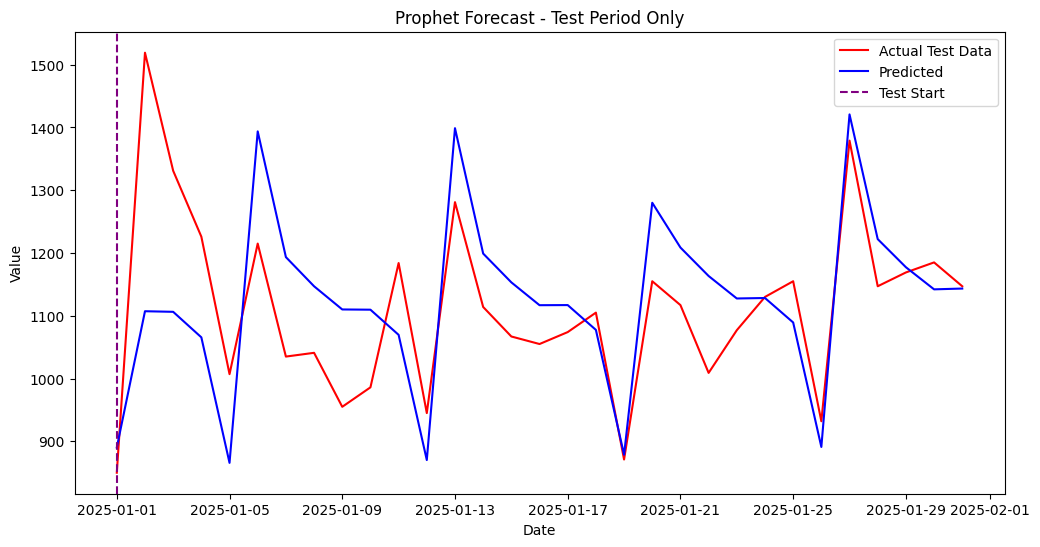

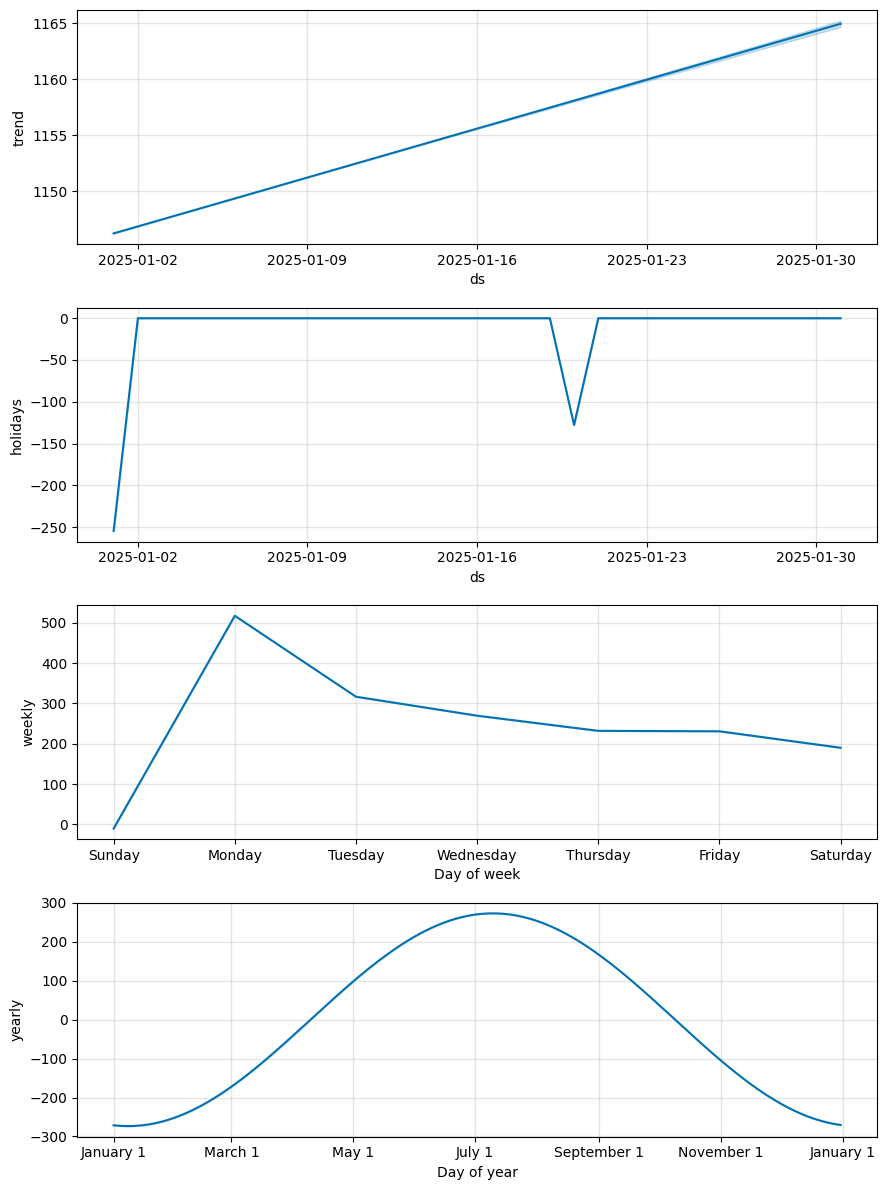

In [ ]:


# Train Prophet Model
best_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    holidays=holidays_df
)
best_model.add_seasonality(name="weekly", period=7, fourier_order=best_params["weekly_fourier_order"])
best_model.add_seasonality(name="yearly", period=365.25, fourier_order=best_params["yearly_fourier_order"])
best_model.fit(train_val)

# Generate Future Dates for Prediction
future_test = best_model.make_future_dataframe(
    periods=len(test),
    include_history=False,
    freq="D"
)

# Make Predictions
forecast_test = best_model.predict(future_test)

# Merge Forecast with Test Data to Avoid Indexing Issues
test_forecast = test.merge(
    forecast_test[["ds", "yhat"]], on="ds", how="left"
)
test_forecast["yhat"].fillna(method="ffill", inplace=True)  # Forward-fill missing values

# Calculate Metrics
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

test_mape = calculate_mape(test_forecast["y"], test_forecast["yhat"])
test_rmse = np.sqrt(mean_squared_error(test_forecast["y"], test_forecast["yhat"]))

print(f"Test MAPE: {test_mape:.4f}%")
print(f"Test RMSE: {test_rmse:.4f}")

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_forecast["ds"], test_forecast["y"], label="Actual Test Data", color="red")
plt.plot(test_forecast["ds"], test_forecast["yhat"], label="Predicted", color="blue")
plt.axvline(pd.to_datetime(test_start), color="purple", linestyle="--", label="Test Start")
plt.legend()
plt.title("Prophet Forecast - Test Period Only")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

# Plot Components
fig = best_model.plot_components(forecast_test)

The MAPE for test data, January 2025 is 8.5%